In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img2 = cv2.imread('img2.png')
img4 = cv2.imread('img4.png')

# Convert images to grayscale
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gray4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)


In [47]:
# Set the parameters for Harris corner detection
window_size = 3
kernel_size = 3
k = 0.04
threshold = 0.01

# Compute the Harris corner response for both images
dx2 = cv2.Sobel(gray2, cv2.CV_64F, 1, 0, ksize=kernel_size)
dy2 = cv2.Sobel(gray2, cv2.CV_64F, 0, 1, ksize=kernel_size)
sift = cv2.SIFT_create()

In [48]:
# find the keypoints and descriptors with SIFT
Ixx2 = dx2**2
Ixy2 = dx2*dy2
Iyy2 = dy2**2

# Gaussian blur the images
sigma = 1
ksize = int(4 * sigma + 1)
Ixx2 = cv2.GaussianBlur(Ixx2, (ksize, ksize), sigma)
Ixy2 = cv2.GaussianBlur(Ixy2, (ksize, ksize), sigma)
Iyy2 = cv2.GaussianBlur(Iyy2, (ksize, ksize), sigma)

# Compute the Harris corner response
det2 = Ixx2 * Iyy2 - Ixy2**2
trace2 = Ixx2 + Iyy2
R2 = det2 - k * trace2**2
R_thresh2 = np.zeros_like(R2)
R_thresh2[R2 > threshold * R2.max()] = 255
keypoints2 = cv2.findNonZero(np.uint8(R_thresh2))

In [49]:
dx4 = cv2.Sobel(gray4, cv2.CV_64F, 1, 0, ksize=kernel_size)
dy4 = cv2.Sobel(gray4, cv2.CV_64F, 0, 1, ksize=kernel_size)
Ixx4 = dx4**2
Ixy4 = dx4*dy4
Iyy4 = dy4**2

# Gaussian blur the images
Ixx4 = cv2.GaussianBlur(Ixx4, (ksize, ksize), sigma)
Ixy4 = cv2.GaussianBlur(Ixy4, (ksize, ksize), sigma)
Iyy4 = cv2.GaussianBlur(Iyy4, (ksize, ksize), sigma)
det4 = Ixx4 * Iyy4 - Ixy4**2
trace4 = Ixx4 + Iyy4
R4 = det4 - k * trace4**2
R_thresh4 = np.zeros_like(R4)
R_thresh4[R4 > threshold * R4.max()] = 255
keypoints4 = cv2.findNonZero(np.uint8(R_thresh4))

In [50]:
# Draw the keypoints on the images
img2_with_keypoints = cv2.findNonZero(np.uint8(R_thresh2))
img4_with_keypoints = cv2.findNonZero(np.uint8(R_thresh4))

for pt in keypoints2:
    x, t = pt[0][0], pt[0][1]
    cv2.circle(img2, (x, t), 1, (0, 0, 255), 1)
for pt in keypoints4:
    x, t = pt[0][0], pt[0][1]
    cv2.circle(img4, (x, t), 1, (0, 0, 255), 1)

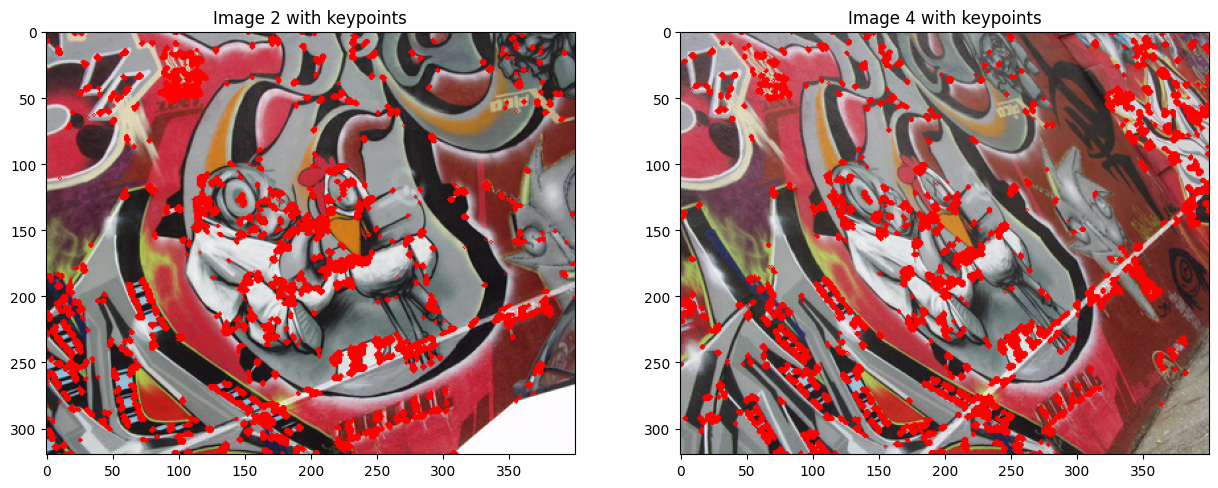

In [51]:
# Display the images
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title('Image 2 with keypoints')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 4 with keypoints')
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.show()

In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img2 = cv2.imread('img2.png')
img4 = cv2.imread('img4.png')

def detectAndCompute(image):
    # Step 1: Compute DoG scale space representation of the image
    octave_count = 4
    scale_count = 5
    k = 2 ** (1 / scale_count)
    sigma = 1.6

    # Create the Gaussian kernels for each octave
    gaussian_kernels = []
    for i in range(octave_count):
        octave_kernels = []
        octave_kernels.append(cv2.getGaussianKernel(3, sigma))
        for j in range(1, scale_count + 3):
            sigma_j = sigma * (k ** j)
            kernel_size = int(2 * np.ceil(3 * sigma_j) + 1)
            kernel = cv2.getGaussianKernel(kernel_size, sigma_j)
            octave_kernels.append(kernel)
        gaussian_kernels.append(octave_kernels)
        sigma *= 2

    # Convolve the image with the Gaussian kernels to get the scale space representation
    dog_images = []
    for i in range(octave_count):
        octave_images = []
        for j in range(scale_count + 2):
            octave_images.append(cv2.filter2D(image, -1, gaussian_kernels[i][j+1] - gaussian_kernels[i][j]))
        dog_images.append(octave_images)

    # Step 2: Identify keypoints as local extrema in scale space
    keypoints = []
    for i in range(octave_count):
        for j in range(1, scale_count + 1):
            for x in range(1, image.shape[1]-1):
                for y in range(1, image.shape[0]-1):
                    if (np.max(dog_images[i][j][y-1:y+2, x-1:x+2]) == dog_images[i][j][y, x]
                            or np.min(dog_images[i][j][y-1:y+2, x-1:x+2]) == dog_images[i][j][y, x]):
                        keypoints.append((i, j, x, y))

    # Step 3: Refine keypoints using Taylor series expansion
    refined_keypoints = []
    for keypoint in keypoints:
        i, j, x, y = keypoint
        dx = (dog_images[i][j][y, x+1] - dog_images[i][j][y, x-1]) / 2.0
        dy = (dog_images[i][j][y+1, x] - dog_images[i][j][y-1, x]) / 2.0
        ds = (dog_images[i][j+1][y, x] - dog_images[i][j-1][y, x]) / 2.0
        dxx = dog_images[i][j][y, x+1] - 2.0 * dog_images[i][j][y, x] + dog_images[i][j][y, x-1]
        dyy = dog_images[i][j][y+1, x] - 2.0 * dog_images[i][j][y, x] + dog_images[i][j][y-1, x]
        dss = dog_images[i][j+1][y, x] - 2.0 * dog_images[i][j][y, x] + dog_images[i][j-1][y, x]
        dxy = (dog_images[i][j][y+1, x+1] - dog_images[i][j][y+1, x-1] - dog_images[i][j][y-1, x+1] + dog_images[i][j][y-1, x-1]) / 4.0
        dxs = (dog_images[i][j+1][y, x+1] - dog_images[i][j+1][y, x-1] - dog_images[i][j-1][y, x+1] + dog_images[i][j-1][y, x-1]) / 4.0
        dys = (dog_images[i][j+1][y+1, x] - dog_images[i][j+1][y-1, x] - dog_images[i][j-1][y+1, x] + dog_images[i][j-1][y-1, x]) / 4.0

        dD = np.array([dx, dy, ds])
        H = np.array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
        offset = -np.linalg.inv(H).dot(dD)
        if np.abs(offset[0]) > 0.5 or np.abs(offset[1]) > 0.5 or np.abs(offset[2]) > 0.5:
            continue
        keypoint = (keypoint[0], keypoint[1] + offset[2], keypoint[2] + offset[0], keypoint[3] + offset[1])
        refined_keypoints.append(keypoint)

    # Step 4:
    orientation_histograms = []
    for keypoint in refined_keypoints:
        i, j, x, y = keypoint
        gaussian_window = cv2.getGaussianKernel(16, 1.5 * keypoint[1])
        orientation_histogram = np.zeros(36)
        for dx in range(-8, 8):
            for dy in range(-8, 8):
                if x+dx < 1 or x+dx >= dog_images[i][j].shape[1]-1 or y+dy < 1 or y+dy >= dog_images[i][j].shape[0]-1:
                    continue
                magnitude = np.sqrt((dog_images[i][j][y+dy, x+dx+1] - dog_images[i][j][y+dy, x+dx-1])**2 + (dog_images[i][j][y+dy+1, x+dx] - dog_images[i][j][y+dy-1, x+dx])**2)
                orientation = np.rad2deg(np.arctan2(dog_images[i][j][y+dy+1, x+dx] - dog_images[i][j][y+dy-1, x+dx], dog_images[i][j][y+dy, x+dx+1] - dog_images[i][j][y+dy, x+dx-1]))
                bin_idx = int(np.floor(orientation / 10.0)) % 36
                orientation_histogram[bin_idx] += magnitude * gaussian_window[dx+8, dy+8]
        orientation_histograms.append(orientation_histogram)

    # Step 5:
    descriptors = []
    for i, keypoint in enumerate(refined_keypoints):
        orientation_histogram = orientation_histograms[i]
        max_bin_idx = np.argmax(orientation_histogram)
        max_bin_value = orientation_histogram[max_bin_idx]
        for bin_idx in range(len(orientation_histogram)):
            if orientation_histogram[bin_idx] >= 0.8 * max_bin_value:
                angle = (bin_idx * 10 + 5) % 360
                cos_angle = np.cos(np.deg2rad(angle))
                sin_angle = np.sin(np.deg2rad(angle))
                descriptor_vector = np.zeros(128)
                for dx in range(-8, 8):
                    for dy in range(-8, 8):
                        if x+dx < 1 or x+dx >= dog_images[keypoint[0]][keypoint[1]].shape[1]-1 or y+dy < 1 or y+dy >= dog_images[keypoint[0]][keypoint[1]].shape[0]-1:
                            continue
                        magnitude = np.sqrt((dog_images[keypoint[0]][keypoint[1]][y+dy, x+dx+1] - dog_images[keypoint[0]][keypoint[1]][y+dy, x+dx-1])**2 + (dog_images[keypoint[0]][keypoint[1]][y+dy+1, x+dx] - dog_images[keypoint[0]][keypoint[1]][y+dy-1, x+dx])**2)
                        orientation = np.rad2deg(np.arctan2(dog_images[keypoint[0]][keypoint[1]][y+dy+1, x+dx] - dog_images[keypoint[0]][keypoint[1]][y+dy-1, x+dx], dog_images[keypoint[0]][keypoint[1]][y+dy, x+dx+1] - dog_images[keypoint[0]][keypoint[1]][y+dy, x+dx-1]))
                        rotated_dx = cos_angle * dx - sin_angle * dy
                        rotated_dy = sin_angle * dx + cos_angle * dy
                        bin_idx = int(np.floor((orientation - angle + 180) / 45.0)) % 8
                        descriptor_vector[bin_idx*16 + int(rotated_dy/2)*4 + int(rotated_dx/2)] += magnitude * gaussian_window[dx+8, dy+8]
                descriptors.append(descriptor_vector)

    descriptors = np.array(descriptors) 
    return refined_keypoints, descriptors



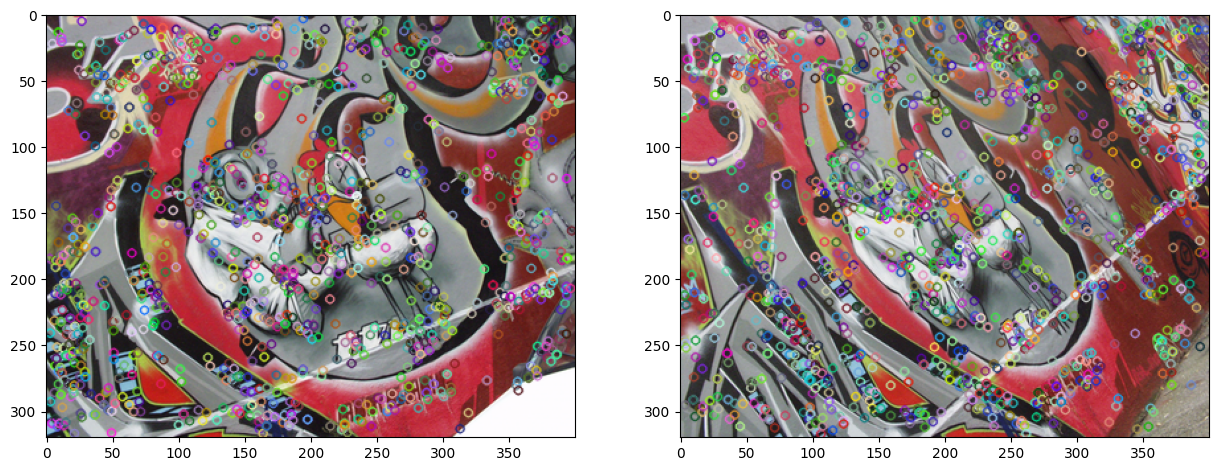

In [53]:

def normalize_and_clip(descriptors):
    descriptors /= np.sqrt(np.sum(descriptors**2, axis=1, keepdims=True))
    descriptors[descriptors > 0.2] = 0.2
    descriptors /= np.sqrt(np.sum(descriptors**2, axis=1, keepdims=True))
    return descriptors

keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
keypoints4, descriptors4 = sift.detectAndCompute(gray4, None)

img_with_keypoints2 = cv2.drawKeypoints(img2, keypoints2, None)
img_with_keypoints4 = cv2.drawKeypoints(img4, keypoints4, None)

plt.figure(figsize=(15, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_with_keypoints2, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(img_with_keypoints4, cv2.COLOR_BGR2RGB))
plt.show()

In [54]:
# Calculate the SSD distances between descriptors in the two images
des1 = normalize_and_clip(descriptors2)
des2 = normalize_and_clip(descriptors4)
distances = np.zeros((des1.shape[0], des2.shape[0]))
for i in range(des1.shape[0]):
    for j in range(des2.shape[0]):
        distances[i, j] = np.sum((des1[i] - des2[j]) ** 2)

In [55]:
# Find the closest and second closest descriptors for each descriptor in the first image
best_matches = np.argmin(distances, axis=1)
second_best_matches = np.argpartition(distances, kth=1, axis=1)[:, 1]

In [56]:
# Calculate the ratio distance for each match
ratio_distances = distances[np.arange(len(best_matches)), best_matches] / distances[np.arange(len(best_matches)), second_best_matches]

# Filter the matches based on a threshold for the ratio distance
good_matches = np.where(ratio_distances < 0.7)[0]

In [57]:
# Initialize FLANN matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match the descriptors using k-nearest neighbors with k=2
matches = flann.knnMatch(descriptors2, descriptors4, k=2)

In [58]:
# Apply ratio test to filter out false matches
good_matches = []
ratio_thresh = 0.7
for match in matches:
    if len(match) == 2 and match[0].distance < ratio_thresh * match[1].distance:
        good_matches.append(match[0])

# Draw the matched keypoints
img_matches = cv2.drawMatches(img2, keypoints2, img4, keypoints4, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


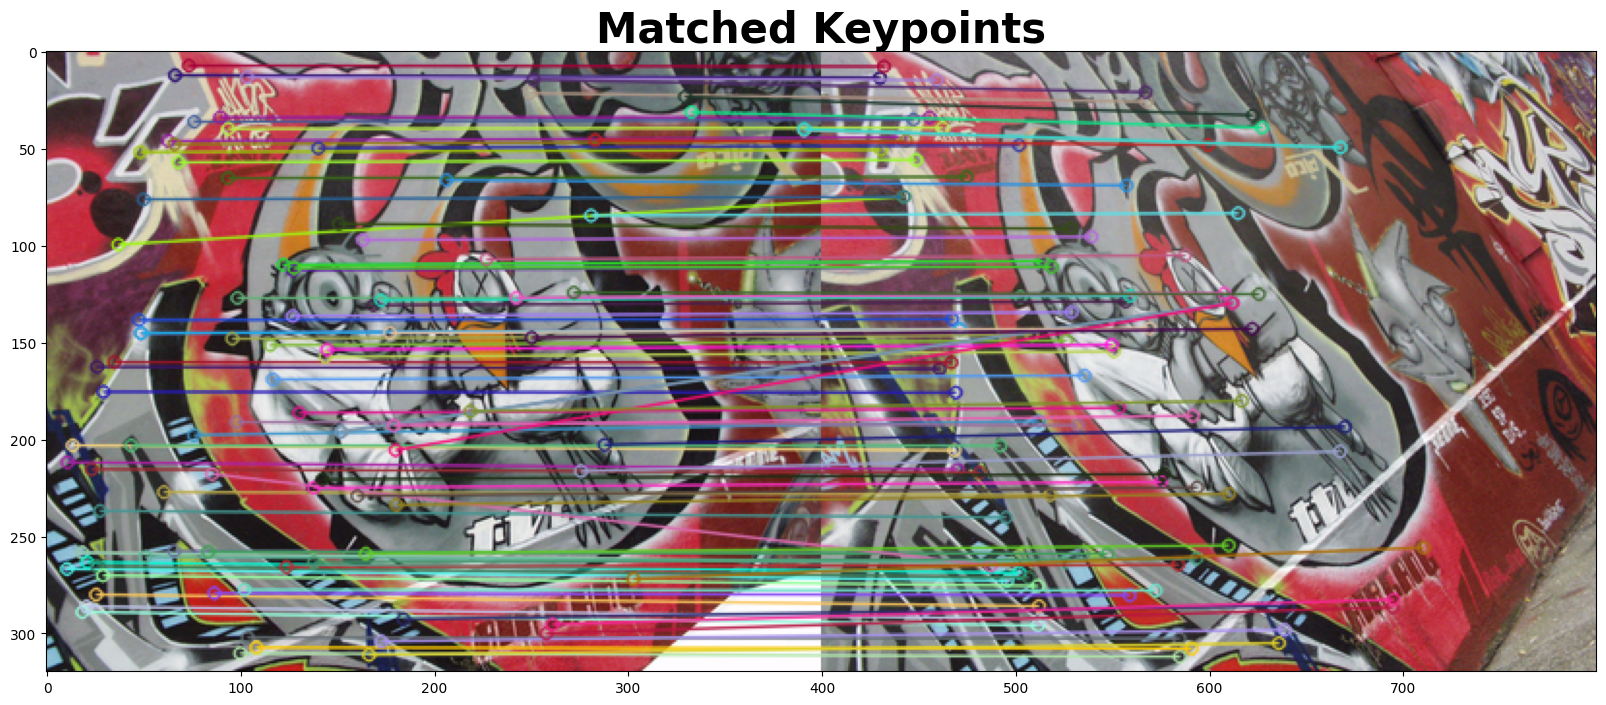

In [59]:
# Display the matched keypoints
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))

bold = {'weight': 'bold', 'size': 30}
plt.title('Matched Keypoints', fontdict=bold)
plt.show()